# Criteo Sponsored Search Conversion Log Dataset Analysis

## Resources
Dataset: [Criteo Sponsored Search Conversion Log Dataset](https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/)

Paper: [Reacting to Variations in Product Demand: An Application for
Conversion Rate (CR) Prediction in Sponsored Search
](https://arxiv.org/pdf/1806.08211.pdf)

## Shortform Overview of the data
- Entire dataset spans 90 days of logs
- Attribution Window used is 30 days
- Each row in the dataset represents an action (i.e. click) performed by the user on a product related advertisement.
- Each row may or may not have a conversion with it. If Sale = 1, then there was a conversion.
- The data has been sub-sampled, and it's not clear how the sampling was done. So, it could be that we have impartial user stories. For instance, multiple impressions might have _actually_ led to a conversion, but that conversion might be missing from the dataset. Similarly, multiple impressions might have _actually_ been recorded, but some impressions might be missing from the dataset. This has implications for accurately recording privacy budget deductions.

## Overview of the data
(Copied from the data source website. Emphasis is mine)

This dataset contains logs obtained from Criteo Predictive Search (CPS). CPS, offers an automated end-to-end solution using sophisticated machine learning techniques to improve Google Shopping experience using robust, predictive optimization across every aspect of the advertiser’s campaign. CPS in general has two main aims : (1) Retarget high-value users via behavioral targeting such that the bids are based on each user’s likelihood to make a purchase. (2) Increase ROI using a bidding strategy which incorporates the effects of product characteristics, user intent, device and user behavior.

**Each row in the dataset represents an action (i.e. click) performed by the user on a product related advertisement**. The product advertisement was shown to the user, post the user expressing an intent via an online search engine.  Each row in the dataset, contains information about the product characteristics (age, brand, gender, price), time of the click ( subject to uniform shift), user characteristics and device information. The **logs also contain information on whether the clicks eventually led to a conversion (product was bought) within a 30 day window and the time between click and the conversion**.

**This dataset represents a sample of 90 days of Criteo live traffic data**. Each line corresponds to one click (product related advertisement) that was displayed to a user. For each advertisement, we have detailed information about the product. Further, we also provide information on whether the click led to a conversion, amount of conversion and the time between the click and the conversion. **Data has been sub-sampled** and anonymized so as not to disclose proprietary elements.

In [1]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
from datetime import datetime
import os
import math
import plotly.express as px

# os.environ["MODIN_ENGINE"] = "ray"

### Dataset Retrieval
This notebook assumes you already have the dataset downloaded and in the current directory. If you do not, uncomment and run the following cell. Note that the uncompressed data is ~6 GB.

In [6]:
# !wget http://go.criteo.net/criteo-research-search-conversion.tar.gz
# !tar -xzf criteo-research-search-conversion.tar.gz

In [2]:
DATA_FILE = 'Criteo_Conversion_Search/CriteoSearchData'
dtype={
    "Sale": np.int32,
    "SalesAmountInEuro": np.float64,
    "Time_delay_for_conversion": np.int32,
    "click_timestamp": np.int32,
    "nb_clicks_1week": pd.Int64Dtype(),
    "product_price": np.float64,
    "product_age_group": str,
    "device_type": str,
    "audience_id": str,
    "product_gender": str,
    "product_brand": str,
    "product_category1": str,
    "product_category2": str,
    "product_category3": str,
    "product_category4": str,
    "product_category5": str,
    "product_category6": str,
    "product_category7": str,
    "product_country": str,
    "product_id": str,
    "product_title": str,
    "partner_id": str,
    "user_id": str,
}
na_values={
    "click_timestamp": "0",
    "nb_clicks_1week": "-1",
    "product_price": "-1",
    "product_age_group": "-1",
    "device_type": "-1",
    "audience_id": "-1",
    "product_gender": "-1",
    "product_brand": "-1",
    "product_category1": "-1",
    "product_category2": "-1",
    "product_category3": "-1",
    "product_category4": "-1",
    "product_category5": "-1",
    "product_category6": "-1",
    "product_category7": "-1",
    "product_country": "-1",
    "product_id": "-1",
    "product_title": "-1",
    "partner_id": "-1",
    "user_id": "-1",
}

In [3]:
df = pd.read_csv(DATA_FILE, names=dtype.keys(), dtype=dtype, na_values=na_values, header=None, sep="\t")
df = df.dropna(subset=['partner_id', 'user_id', "product_id"])
df.head()

,Sale,SalesAmountInEuro,Time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,...,product_category3,product_category4,product_category5,product_category6,product_category7,product_country,product_id,product_title,partner_id,user_id
0,0,-1.0,-1,1598891820,<NA>,0.00,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,A66DB02AC1726A8D79C518B7F7AB79F0,NaN,E3DDEB04F8AFF944B11943BB57D2F620,493CFB4A87C50804C94C0CF76ABD19CD
1,0,-1.0,-1,1598925284,0,0.00,4C90FD52FC53D2C1C205844CB69575AB,D7D1FB49049702BF6338894757E0D959,NaN,1B491180398E2F0390E6A588B3BCE291,...,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,4C6C62203B4CE5AA6DFCF17F2604DC37,3CE3D1623D32FB2A901822910AF72A0B C83584C673752...,BD01BAFAE73CF38C403978BBB458300C,D0EBCD4402172AE3AA6FD21FB77BDE84
4,0,-1.0,-1,1598905245,<NA>,0.00,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,5F4AFF2693601C2EFFE9AF2C1ED4222E,NaN,E3DDEB04F8AFF944B11943BB57D2F620,703B8CFC8D65A67BDF96595CCF992D27
5,1,89.9,442485,1598929598,9,49.95,0CD76C7030D0900BE250C8D41703D180,D7D1FB49049702BF6338894757E0D959,NaN,A5D15FC386510762EC0DDFF54ABE6F94,...,F791095E78AAC9F6A0C9D4948E6AA729,E970B6E90DCE5E7769360E6BD6532433,17B7ED5C6FE3EF8EC27330318AE867B9,NaN,NaN,D963E3BCE149E71F5D5E3000DCF68A9F,C806140F3AF11759BEF4E3B79B51588F,5678890DC6A51DC56FF0BCBD5A7E99AD 9EBC9598EC9B3...,743B1EE3A39E06D855A72B3B66D501D0,E94BA61ACE2488B7DA7920736B82DFBD
6,0,-1.0,-1,1598940008,<NA>,0.00,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,EE31CDA023E1237FBAD9C75E08C1D2BF,NaN,E3DDEB04F8AFF944B11943BB57D2F620,B361216FD8F17C7F748DFAC7EEA9C231


In [4]:
conversions = df.loc[(df.Sale == 1)]

dimension: product_category1
   partner_id,product_category1  count
0                   E3...,7F...  86181
1                   E3...,62...  74884
2                   9D...,03...  53758
3                   E3...,75...  41538
4                   31...,03...  28134
5                   E3...,B4...  27013
6                   F1...,E0...  25278
7                   9F...,03...  24653
8                   9F...,7F...  19404
9                   E3...,E0...  17371
10                  4D...,63...  14656
11                  8C...,13...  13043
12                  A5...,62...  11597
13                  88...,62...  11479
14                  C2...,03...  11177
15                  E3...,21...  10579


dimension: product_category2
   partner_id,product_category2  count
0                   E3...,93...  47596
1                   9D...,77...  37927
2                   E3...,A7...  24523
3                   31...,77...  24307
4                   9F...,77...  23039
5                   E3...,47...  18068
6   

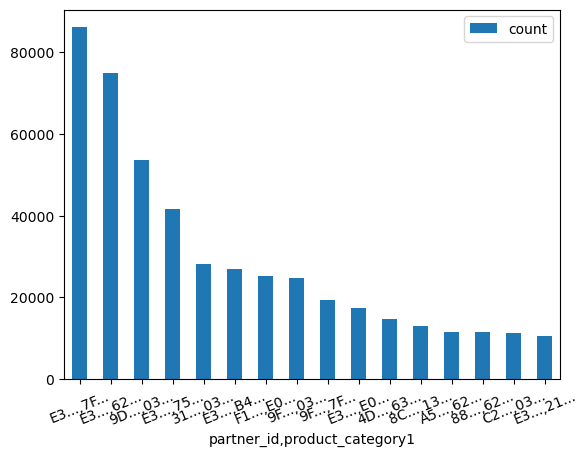

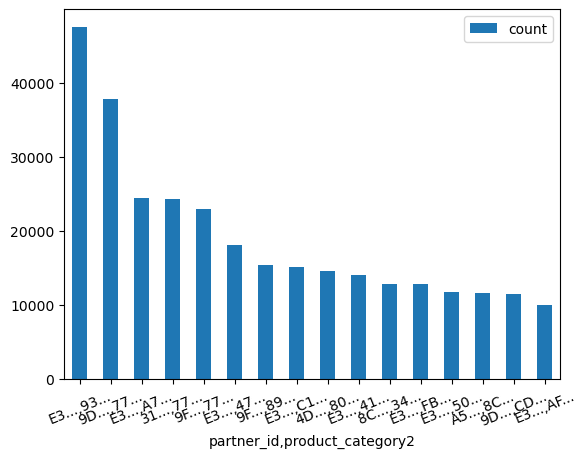

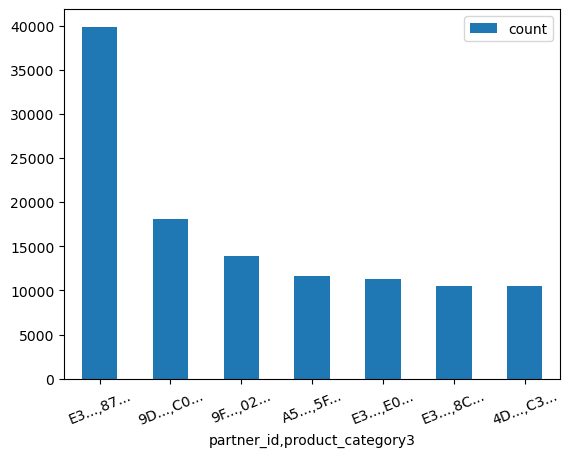

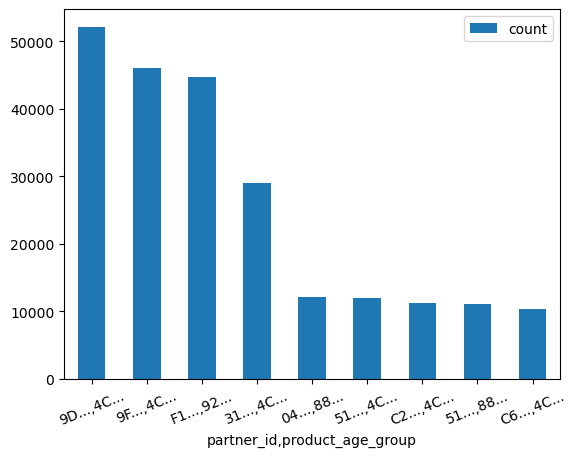

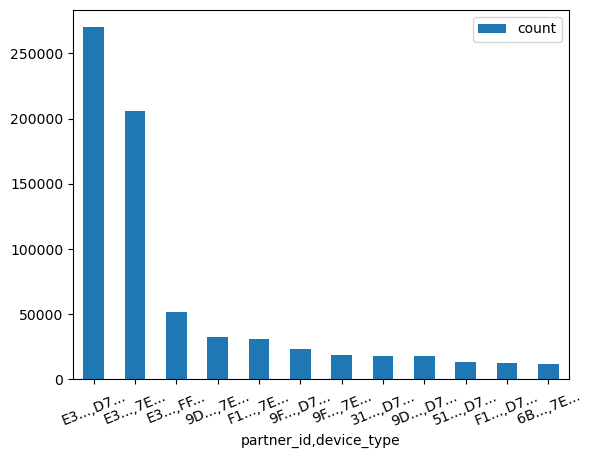

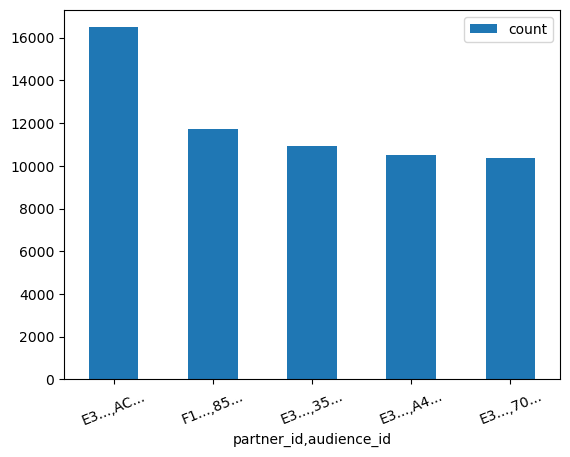

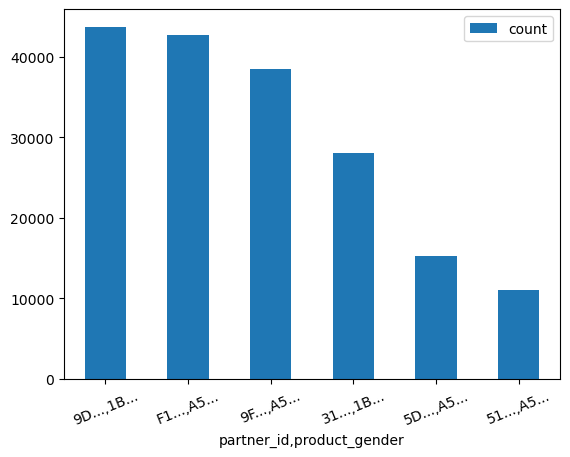

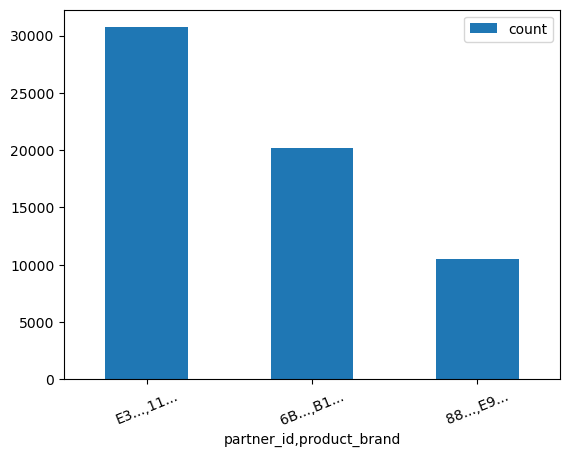

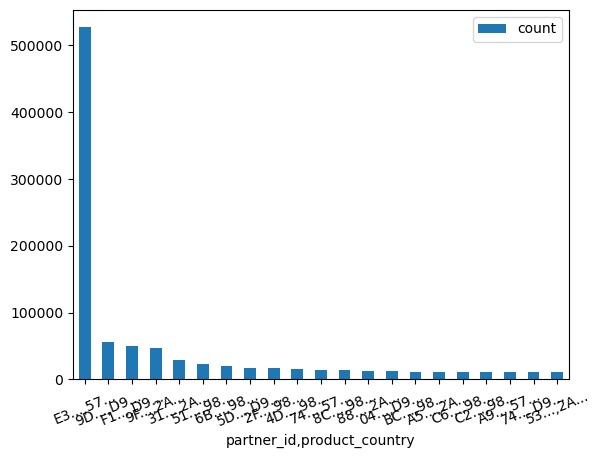

In [28]:

dimensions = ['product_category1', 'product_category2', 'product_category3', 
              'product_category4', 'product_category5', 'product_category6', 'product_category7',
              'product_age_group', 'device_type', 'audience_id', 'product_gender', 'product_brand',
              'product_country', 'bucket_into2', 'bucket_into4', 'bucket_into6',
             ]

"""
DO THIS IN THE DF STEP


bucket_groupN
- bg3_1
- bg3_2
- bg3_3
- ...
- bgN_N

EXAMPLE:
advertiser A has M=50k conversions  45k product_category1=X, 5k product_category1=Y, 0 product_category=Z
B=20,000

M/B = N

bucket_groupN
- bg3_1
- bg3_2
- bg3_3
- ...
- bgN_N


...



bucket_group1
- bg2_1



----------

product_category1
- X


- way to identify the query to run by looking up in the query pool and create C conversion records for each one that matches
- append in order of group domain cardinality descending.


"""

for dimension in dimensions:
    query = conversions.groupby(['partner_id', dimension]).Sale.count()
    query = query[query > 10_000].sort_values(ascending=False)
    if query.shape[0] > 2:
        print(f"dimension: {dimension}")
        # print(query.index)
        partner_dim = query.index.map(lambda x: f"{x[0][:2]}...,{x[1][:2]}...")
        columns = [f"partner_id,{dimension}", "count"]
        dim_df = pd.DataFrame(list(zip(partner_dim.values, query.values)), columns = columns)
        print(dim_df)
        dim_df.plot.bar(x=columns[0], y=columns[1], rot=22)
        print("\n")

In [23]:
print(df["click_timestamp"].min())
df["click_timestamp"].max()

df["click_timestamp"] = df["click_timestamp"] - df["click_timestamp"].min()
df["click_timestamp"].min()

1596439471


0

In [30]:
df["click_datetime"] = df["click_timestamp"].apply(lambda x: datetime.fromtimestamp(x))
df["click_datetime"].min()
df["click_day"] = df["click_datetime"].apply(
    lambda x: (7 * (x.isocalendar().week - 1)) + x.isocalendar().weekday
)
df["click_day"]


0           32
1           32
4           32
5           32
6           32
            ..
15995629    10
15995630    10
15995631     9
15995632     9
15995633    10
Name: click_day, Length: 12167296, dtype: int64

In [31]:
df["click_timestamp"] = df["click_timestamp"] - df["click_timestamp"].min()
df["click_datetime"] = df["click_timestamp"].apply(lambda x: datetime.fromtimestamp(x))
df["click_day"] = df["click_datetime"].apply(
    lambda x: (7 * (x.isocalendar().week - 1)) + x.isocalendar().weekday
)

df["conversion_timestamp"] = df["Time_delay_for_conversion"] + df["click_timestamp"]
df["conversion_datetime"] = df["conversion_timestamp"].apply(
    lambda x: datetime.fromtimestamp(x)
)
df["conversion_day"] = df["conversion_datetime"].apply(
    lambda x: (7 * (x.isocalendar().week - 1)) + x.isocalendar().weekday
)


df = df.query(
    "partner_id=='F122B91F6D102E4630817566839A4F1F' and user_id == '34951B67071368AAB361548D35DF978B'"
)
def hash_to_buckets(s):
    print(s)
    hash_value = hash(s)
    normalized_hash = (hash_value % 10000) / 10000
    if normalized_hash < 1 / 3:
        return 0
    elif normalized_hash < 2 / 3:
        return 1
    else:
        return 2

df["product_id_group"] = df["product_id"].apply(hash_to_buckets)
df["filter"] = "product_group_id=" + df["product_id_group"].astype(str)
# df
# df[["product_id_group", "product_id"]]

BFACB58E2C452E7C227802C3D6155F20


In [32]:
# Get impressions
impressions = df[
    [
        "click_timestamp",
        "click_day",
        "user_id",
        "partner_id",
        "product_id_group",
        "filter",
    ]
]
impressions = impressions.sort_values(by=["click_timestamp"])
impressions["key"] = "purchaseCount"

# Get conversions
conversions = pd.DataFrame(df.loc[df.Sale == 1])[
    [
        "conversion_timestamp",
        "conversion_day",
        "user_id",
        "partner_id",
        "product_id_group",
        "filter",
        "SalesAmountInEuro",
        "product_price",
        "Time_delay_for_conversion"
    ]
]
conversions = conversions.sort_values(by=["conversion_timestamp"])

In [33]:
# impressions.query("partner_id == '9FF550C0B17A3C493378CB6E2DEEE6E4' and user_id == '52608AC73B7E4DEDE6A5392D5C36A834'")
impressions

,click_timestamp,click_day,user_id,partner_id,product_id_group,filter,key
1854160,138455,5,34951B67071368AAB361548D35DF978B,F122B91F6D102E4630817566839A4F1F,1,product_group_id=1,purchaseCount


In [34]:
# conversions.query("conversion_timestamp==1599026856 and user_id == '52608AC73B7E4DEDE6A5392D5C36A834'")
conversions

,conversion_timestamp,conversion_day,user_id,partner_id,product_id_group,filter,SalesAmountInEuro,product_price,Time_delay_for_conversion
1854160,2670963,34,34951B67071368AAB361548D35DF978B,F122B91F6D102E4630817566839A4F1F,1,product_group_id=1,47.28,5.87,2532508


In [12]:
# conversions.loc[conversions['SalesAmountInEuro'] < conversions['product_price'], 'SalesAmountInEuro'] = conversions['product_price']
# cap_value = 5
# conversions["count"] = conversions["SalesAmountInEuro"] // conversions["product_price"]
# conversions = conversions.drop(columns=["product_price", "SalesAmountInEuro"])
# conversions.loc[conversions['count'] > cap_value, 'count'] = cap_value
# conversions["count"].describe()

In [13]:
# def get_epsilon_from_accuracy(n):
#     s = cap_value
#     a = 0.05
#     b = 0.01
#     return s * math.log(1 / b) / (n * a)

# # Get epsilons from accuracy
# x = (
#     conversions.groupby(["partner_id", "product_id_group"])
#     .size()
#     .reset_index(name="count")
# )
# x["epsilon"] = x["count"].apply(get_epsilon_from_accuracy)
# x = x.drop(columns=["count"])
# conversions = conversions.merge(x, on=["partner_id", "product_id_group"], how="left")

# conversions["aggregatable_cap_value"] = cap_value
# conversions["key"] = "product_group_id=" + conversions["product_id_group"].astype(str)

# epsilons = s * math.log(1/b) / (df["num_conversions"] * a)

In [14]:
# x.groupby(["partner_id", "product_id_group"]).max()["epsilon"]

In [15]:
# total_impressions = impressions.shape[0]
# total_conversions = conversions.shape[0]
# unique_user_count = len(df.groupby(['user_id']).count())
# unique_partner_count = len(df.groupby(['partner_id']).count())
# unique_product_count = len(df.groupby(['product_id']).count())
# unique_partner_product_count = len(df.groupby(['partner_id', 'product_id']).size())

# print("total impressions:", total_impressions, "total conversions:", total_conversions)
# print("conversion rate:", total_conversions/total_impressions*100, "%")
# print("unique users:", unique_user_count)
# print("unique partners:", unique_partner_count)
# print("unique products:", unique_product_count)
# print("unique per partner products :", unique_partner_product_count)